In [9]:
import tensorflow as tf 
from tensorflow import keras 
from tensorflow.keras import layers 
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Conv2D, Activation, MaxPooling2D, Dropout, Flatten

import tensorflow_addons as tfa
import cv2
import os 
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import datetime

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import mean_absolute_error
import random 
import math
import time
import pandas as pd

In [2]:
base_models_path = 'C:/Users/user/Desktop/models/child_skin_classification'
PATH = 'C:/Users/user/Desktop/datasets/Child Skin Disease'
# PATH = '../../datasets/Child Skin Disease'
dataset = os.path.join(PATH, 'Total_Dataset')
N_RES = 256

min_num = 100
max_num = 3000 
base_num = 1000 

name_dict = {
    'Depressed scar' : 'Acne scar', 
    'Acquired tufted hemangioma' : 'Acquired tufted angioma', 
    'Cyst' : 'Epidermal cyst', 
    'Infantile hemangioma' : 'Hemangioma',
    'ILVEN': 'Inflammatory linear verrucous epidermal nevus'
}

In [3]:
def label_2_index(lbl, label_dict):
    return label_dict[lbl]

def index_2_label(idx, label_dict):
    key = [keys for keys in label_dict if (label_dict[keys] == idx)]
    return key

In [4]:
def test_generator(images, labels):
    
    for img, lbl in zip(images, labels):
        
        img = img[0].decode('utf-8')
        
        img = cv2.imread(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (N_RES, N_RES))
        img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)

        yield (img, lbl)    

In [7]:
def create_test_list(dataset, all_dict):
    
    images = []
    for i in range(7, 9):

        for key, val in all_dict.items():
            img = glob(dataset + f'/H{str(i)}/{key}/*.jpg')
            images.extend(img)

        for key, val in name_dict.items():
            img = glob(dataset + f'/H{str(i)}/{key}/*.jpg')
            images.extend(img)

        
    # # 전남대 추가
    # for key, val in all_dict.items(): 
    #     img = glob(dataset + '/H9/{key}/*.jpg')
    #     images.extend(img) 

    # for key, val in name_dict.items():
    #     img = glob(dataset + f'/H9/{key}/*.jpg')
    #     images.extend(img)

    # 고른 데이터 분배를 위한 random shuffle
    random.shuffle(images)

    # max 데이터 처리
    # count 를 돌면서 count
    # count_all_dict = all_dict.copy() 

    test_images = []
    for idx_imgs, val_imgs in enumerate(images):

        # class 통합 관련 내용 변경
        classes = val_imgs.split('/')[-1].split('\\')[0]
        # classes = val_imgs.split('/')[-2]
        
        test_images.append(val_imgs)
        
        # if classes in name_dict:
        #     if count_all_dict[name_dict[classes]] > 0:
        #         count_all_dict[name_dict[classes]] -= 1
        #         test_images.append(val_imgs)

        #     else:
        #         continue

        # else:
        #     if count_all_dict[classes] > 0:
        #         count_all_dict[classes] -= 1
        #         test_images.append(val_imgs)
        #     else:
        #         continue


    test_labels = [] 
    for img in test_images:
        lbl = img.split('/')[-1].split('\\')[0]
        # lbl = img.split('/')[-2]

        # 변경/통합 버전으로 label 처리
        if lbl in name_dict:
            lbl = name_dict[lbl]

        lbl = label_2_index(lbl, all_dict)
        test_labels.append(lbl)
        
    test_images = np.reshape(test_images, [-1, 1])
    test_labels = np.reshape(test_labels, [-1, 1])
    
    
    return test_images, test_labels

In [8]:
# test_images, test_labels
x_test = [] 
y_test = [] 
N_RES = 256

for img, lbl in zip(test_images, test_labels): 
    # print(img[0])
    
    img = cv2.imread(img[0], cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (N_RES, N_RES))
    img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)
    
    x_test.append(img) 
    y_test.append(lbl) 
    
x_test = np.reshape(x_test, [-1, N_RES, N_RES, 3])
y_test = np.reshape(y_test, [-1, 1])

x_test.shape, y_test.shape

NameError: name 'test_images' is not defined

In [29]:
def create_dataset(images, labels, d_type='train', aug=False):
    
    if d_type == 'test':
        return tf.data.Dataset.from_generator(test_generator, 
                                              output_types=(tf.float64, tf.float32), 
                                              output_shapes=(tf.TensorShape([N_RES, N_RES, 3]), tf.TensorShape([1])),
                                              args=[images, labels])
        
    else:
        pass
        # return tf.data.Dataset.from_generator(train_generator, 
        #                                       output_types=(tf.float64, tf.float32), 
        #                                       output_shapes=(tf.TensorShape([N_RES, N_RES, 3]), tf.TensorShape([1])),
        #                                       args=[images, labels, aug])

In [7]:
def create_all_dict(dataset, min_num, max_num):
    all_dict = dict() 
    count_all_dict = dict() 

    for i in range(10):
        files = os.listdir(os.path.join(dataset, f'H{i}'))
        
        for f in files:
            # imgs = glob(os.path.join(dataset, f'H{i}', f) + '/*.jpg')
            imgs = glob(f'{dataset}/H{i}/{f}/*.jpg')
            
            # print(f)

            # class 통합 관련 내용 변경
            if f in name_dict: 
                f = name_dict[f]
            
            if f not in count_all_dict:
                count_all_dict[f] = len(imgs) 
            else:
                count_all_dict[f] += len(imgs)

    new_count_dict = count_all_dict.copy()

    # print(new_count_dict)

    # 데이터 정제
    for key, val in count_all_dict.items():
        if val < min_num:
            del new_count_dict[key]

        if val > max_num:
            new_count_dict[key] = max_num
            

    idx_num = 0 
    for idx, key in new_count_dict.items():
        # print(idx)
        all_dict[idx] = idx_num 
        idx_num += 1 
        
        
    return all_dict, count_all_dict

In [8]:
all_dict, count_all_dict = create_all_dict(dataset, min_num, max_num) 
N_CLASSES = len(all_dict)

# all_dict, count_all_dict

In [9]:
# train_dataset = create_dataset(train_images[valid_idx], train_labels[valid_idx]) 
test_images, test_labels = create_test_list(dataset, all_dict)

test_images

array([['C:/Users/user/Desktop/datasets/Child Skin Disease\\Total_Dataset/H7/Skin tag\\H7_1199_P2_L0.jpg'],
       ['C:/Users/user/Desktop/datasets/Child Skin Disease\\Total_Dataset/H7/Alopecia areata\\H7_4194_P7_L1.jpg'],
       ['C:/Users/user/Desktop/datasets/Child Skin Disease\\Total_Dataset/H8/Normal\\H8_996_P12_L0.jpg'],
       ...,
       ['C:/Users/user/Desktop/datasets/Child Skin Disease\\Total_Dataset/H7/Purpura\\H7_6028_P2_L2.jpg'],
       ['C:/Users/user/Desktop/datasets/Child Skin Disease\\Total_Dataset/H7/Erythema dyschromicum perstans\\H7_5529_P40_L1.jpg'],
       ['C:/Users/user/Desktop/datasets/Child Skin Disease\\Total_Dataset/H7/Toxic epidermal necrolysis\\H7_6109_P13_L5.jpg']],
      dtype='<U134')

In [33]:
test_dataset = create_dataset(test_images, test_labels, d_type='test') 
test_dataset

c:\ProgramData\Miniconda3\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


<FlatMapDataset element_spec=(TensorSpec(shape=(256, 256, 3), dtype=tf.float64, name=None), TensorSpec(shape=(1,), dtype=tf.float32, name=None))>

In [19]:
# model = keras.models.load_model(os.path.join(base_models_path, 'checkpoint_efficient_mc-False_bs-16_20220711-100710.h5'))
res = 256 

def create_model():
    base_model = keras.applications.EfficientNetB7(include_top=False, input_shape=(res, res, 3),  weights = 'imagenet')
    base_model.trainable = True
    
    inputs = keras.Input(shape=(res, res, 3))
    x = base_model(inputs)
    x = keras.layers.GlobalAveragePooling2D()(x) 
    # x = get_dropout(x, mc)
    x = Dropout(0.3, name='top_dropout')(x, training=False)
    x = keras.layers.Dense(N_CLASSES, activation='softmax')(x)
    model = tf.keras.Model(inputs=inputs, outputs=x)
    
    return model

In [34]:
test_dataset = test_dataset.batch(16).shuffle(1000)

In [20]:
# weght
model = create_model()
model.compile(loss='sparse_categorical_crossentropy', 
            #   optimizer = moving_avg_sgd, 
                optimizer = tf.keras.optimizers.Adam(0.0001), 
            #   optimizer = tf.keras.optimizers.Adam(lr_schedule), 
                metrics=['accuracy'])

model.load_weights(os.path.join(base_models_path, 'checkpoint_efficient_mc-False_bs-16_20220711-100710.h5'))

loss, acc = model.evaluate(test_dataset)

In [35]:
model = keras.models.load_model(os.path.join(base_models_path, '20220711-161501_efficientb4_kfold_5_0.h5'))


In [36]:
loss, acc = model.evaluate(test_dataset)


2588/2588 [==============================] - 636s 206ms/step - loss: 6.8100 - accuracy: 0.2476


In [10]:
df = pd.read_csv(os.path.join(base_models_path, '20220718-134018_efficientb4_kfold_10_9.csv'))
df 

,Unnamed: 0,loss,accuracy,val_loss,val_accuracy
0,0,2.800492,0.348897,2.224504,0.442831
1,1,2.022683,0.476115,2.092239,0.477390
2,2,1.766162,0.529195,2.038153,0.490993
3,3,1.601237,0.564514,2.039959,0.494118
4,4,1.490323,0.587585,1.995551,0.504963
5,5,1.410761,0.606913,2.047223,0.501471
6,6,1.333376,0.623759,2.030916,0.512316
7,7,1.274893,0.637146,2.056993,0.506801
8,8,1.230281,0.647441,2.090637,0.506801


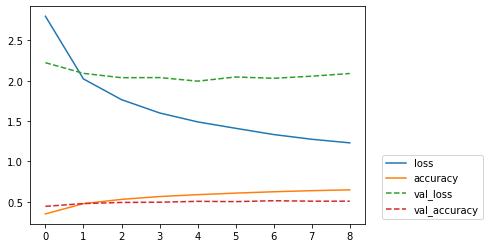

In [11]:
plt.plot(df['loss'], label='loss')
plt.plot(df['accuracy'], label='accuracy')
plt.plot(df['val_loss'], '--', label='val_loss')
plt.plot(df['val_accuracy'], '--', label='val_accuracy')
plt.legend(loc=(1.05, 0.02))
plt.show()

In [4]:
# PATH = 'C:/Users/user/Desktop/Child Skin Disease'

# Train & test set
min_num = 100
max_num = 3000 
base_num = 1000 # baseline of data augmentation

train_dict = {}
test_dict = {} 

for i in range(6):
    files = os.listdir(os.path.join(dataset, f'H{i}'))
    
    for f in files: 
        imgs = glob(os.path.join(dataset, f'H{i}', f) + '/*.jpg')
        
        if len(imgs) > min_num and len(imgs) <= max_num: 
            
            if f in train_dict:
                train_dict[f] = train_dict[f] + len(imgs)
            else:
                train_dict[f] = len(imgs)
            
for i in range(7, 10): 
    files = [val for val in list(train_dict.keys())]
    
    for f in files:
        imgs = glob(os.path.join(dataset, f'H{i}', f) + '/*.jpg')
        
        if f in test_dict:
            test_dict[f] = test_dict[f] + len(imgs) 
        else:
            test_dict[f] = len(imgs) 

N_CLASSES = len(train_dict)

In [5]:
N_CLASSES

78

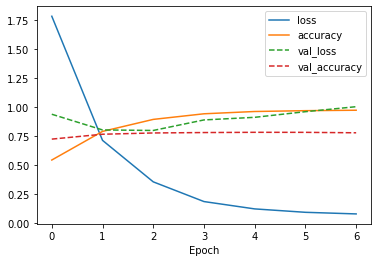

In [7]:
import matplotlib.pyplot as plt 

plt.plot(df['loss'], label='loss')
plt.plot(df['accuracy'], label='accuracy')
plt.plot(df['val_loss'], '--', label='val_loss')
plt.plot(df['val_accuracy'], '--', label='val_accuracy')
plt.xlabel('Epoch')
plt.legend() 
plt.show()

In [8]:
label_to_index = {}
for idx, key in zip(range(len(train_dict)), train_dict.keys()):
    label_to_index[key] = idx

In [9]:
def test_skin_data(files):
    
    for file in files:
    
        f = file.decode('utf-8')
        
        img = cv2.imread(f, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (N_RES, N_RES))
        img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)
        
        # lbl = tf.keras.utils.to_categorical(label_to_index[f.split('\\')[1].split('/')[2]], len(train_dict))
        idx = f.split('\\')[2]
        
        # key = 0 
        # if idx in effection:
        #     key = 1 
            
        lbl = tf.keras.utils.to_categorical(label_to_index[key], N_CLASSES)

        yield (img, lbl)    

In [10]:
imgs = [] 
for i in range(7, 9):
    # for key in train_dict.keys():
    img = glob(dataset + f'/H{str(i)}/*/*.jpg')
    imgs.extend(img) 

In [12]:
N_BEF_RES = 256

# def test_skin_data(files):

test_images = [] 
test_labels = [] 

for f in imgs:

    # f = file.decode('utf-8')
    
    img = cv2.imread(f, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (N_BEF_RES, N_BEF_RES))
    img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)
    
    # print(f)
    idx = f.split('\\')[-2]
    # print(idx) 
    
    # key = 0 
    # if idx in effection:
    #     key = 1 
         
    # lbl = tf.keras.utils.to_categorical(key, 2)
    lbl = tf.keras.utils.to_categorical(label_to_index[key], N_CLASSES)
    
    test_images.append(img)
    test_labels.append(lbl) 
    
test_images = np.reshape(test_images, [-1, N_BEF_RES, N_BEF_RES, 3])
test_labels = np.reshape(test_labels, [-1, N_CLASSES])

In [11]:
# model = keras.models.load_model(os.path.join(base_models_path, '20220701-213304_efficientb4_infection.h5'), custom_objects={'focal_loss_fixed' : tfa.losses.SigmoidFocalCrossEntropy()})


model = keras.models.load_model(os.path.join(base_models_path, '20220701-213304_efficientb4_infection.h5'))

In [12]:
y_test_1 = tf.keras.utils.to_categorical(y_test, N_CLASSES)

In [13]:
# test_preds = model.predict(test_images)
test_preds = model.predict(x_test)


In [14]:
import sklearn 
from sklearn.metrics import roc_curve
from sklearn.metrics import auc 
import seaborn as sns


# cm = sklearn.metrics.confusion_matrix(test_labels.argmax(axis=1), test_preds.argmax(axis=1))
cm = sklearn.metrics.confusion_matrix(y_test_1.argmax(axis=1), test_preds.argmax(axis=1))



In [48]:
model.evaluate(x_test, y_test)

c:\ProgramData\Miniconda3\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1294/1294 [==============================] - 270s 208ms/step - loss: 6.8100 - accuracy: 0.2476


[6.810032367706299, 0.24760271608829498]

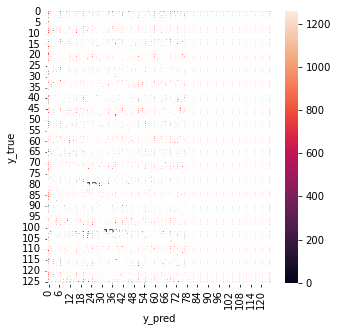

In [15]:
import seaborn as sns

f, ax = plt.subplots(figsize=(5,5))
sns.heatmap(cm, annot=True, linewidths=0.5, linecolor='red', fmt='.0f', ax=ax)
plt.xlabel('y_pred')
plt.ylabel('y_true')

plt.show()

In [16]:
f1_score = sklearn.metrics.f1_score(y_test_1.argmax(axis=1), test_preds.argmax(axis=1), average='micro')
f1_score


0.003454022849689621

In [17]:

precision = sklearn.metrics.precision_score(y_test_1.argmax(axis=1), test_preds.argmax(axis=1), average='micro')
recall = sklearn.metrics.recall_score(y_test_1.argmax(axis=1), test_preds.argmax(axis=1), average='micro')

precision, recall

(0.003454022849689621, 0.003454022849689621)